# Whole brain data processing

In [79]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing_single_WS import *
import zarr
import scipy.ndimage.filters as sfilter
from utils import intesity_mask
from fish_proc.utils.snr import local_correlations_fft

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
dir_root = '/nrs/ahrens/jing/giving_up/20190430/fish01/6dpf_HuC-GCaMP7ff-GFAP-RGECO_GU-slow-fwd_fish01_exp01_20190430_174349/im'
save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190430/fish01/6dpf_HuC-GCaMP7ff-GFAP-RGECO_GU-slow-fwd_fish01_exp01_20190430_174349/'
dask_tmp = '/opt/data/weiz/dask-worker-space'
memory_limit = 0 # unlimited

nsplit = (8, 16)

In [81]:
# cluster, client = fdask.setup_workers(is_local=True, dask_tmp=dask_tmp, memory_limit=memory_limit)
# print_client_links(cluster)
# Y_d = zarr.open(f'{save_root}/Y_max.zarr', 'r')
# mask = zarr.open(f'{save_root}/mask_map.zarr', 'r')
# for n, n_ave_ in enumerate(Y_d):
#     _ = n_ave_.squeeze().copy()
#     _[~mask[n].squeeze()] = 0
#     plt.imshow(_, vmax=np.percentile(_, 99))
#     plt.title(n)
#     plt.show()
# fdask.terminate_workers(cluster, client)

## df data after denoising

In [4]:
Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
Y_pca = da.from_zarr(f'{save_root}/masked_local_pca_data.zarr')

In [5]:
Y_pca

,Array,Chunk
Bytes,2.10 TB,776.72 MB
Shape,"(21, 1108, 2048, 10993)","(1, 138, 128, 10993)"
Count,3025 Tasks,3024 Chunks
Type,float32,numpy.ndarray


#### Take one block data for validation of denoise using local correlation

In [82]:
block_id = (8, 4, 1, 0)

In [83]:
x = Y_d.blocks[block_id].compute()
x_ = Y_pca.blocks[block_id].compute()

In [84]:
from fish_proc.utils.snr import local_correlations_fft

In [85]:
# Cblock = local_correlations_fft(x.squeeze(), is_mp=False)
# plt.imshow(Cblock) # , vmin=0.6, vmax=0.9
# plt.axis('off')
# plt.colorbar()
# plt.title('Local correlation -- Raw image')
# plt.show()

# Cblock_ = local_correlations_fft(x_.squeeze(), is_mp=False)
# plt.imshow(Cblock_) #, vmin=0.8, vmax=1.0
# plt.axis('off')
# plt.colorbar()
# plt.title('Local correlation -- Denoised image')
# plt.show()

# Cblock_ = x.max(axis=-1,keepdims=True).squeeze()
# plt.imshow(Cblock_) #, vmin=0.8, vmax=1.0
# plt.axis('off')
# plt.colorbar()
# plt.title('Local correlation -- Denoised image')
# plt.show()

58


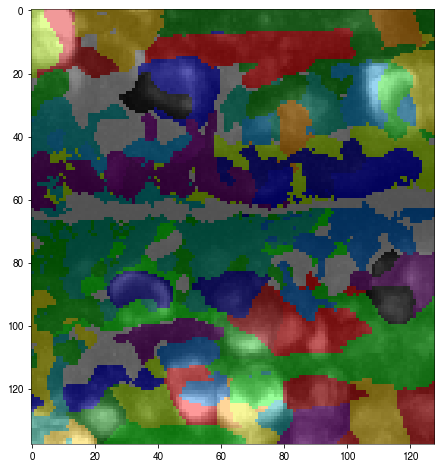

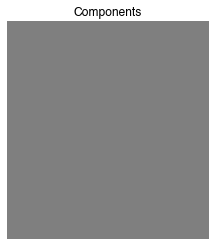

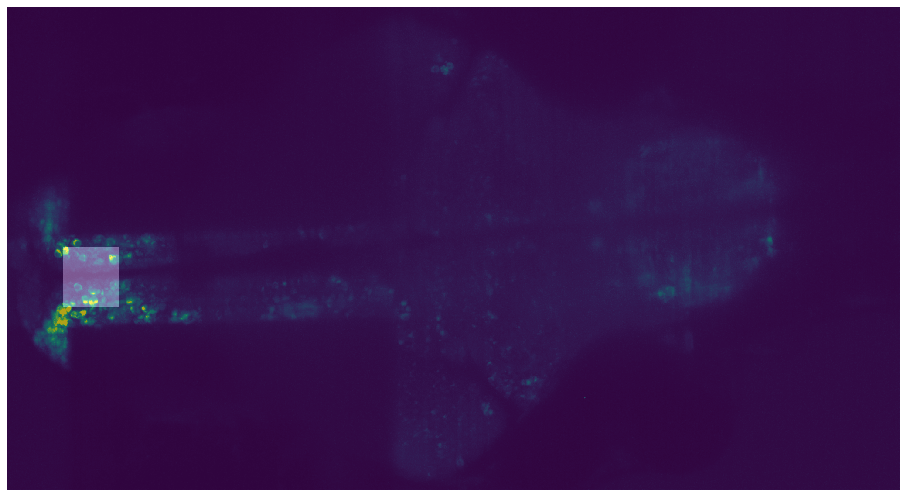

In [86]:
check_demix_cells(save_root, block_id, plot_global=True, plot_mask=True)

## Compute df/f
One of three choices
* df is from NMF components (where background is not included) -- preferred
* df is on raw data based on the recomputation of cell F using NMF weights
* df/f on pixels without using NMF weights

### df/f on pixels

In [ ]:
# dff on raw data
trans_data_t = da.from_zarr(f'{save_root}/motion_corrected_data.zarr')
Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
baseline_t = da.map_blocks(baseline_from_Yd, trans_data_t, Y_d, dtype='float32')
_, nx, ny, _ = trans_data_t.chunksize
dff = Y_d/baseline_t

# dff on denoised data
Y_svd = da.from_zarr(f'{save_root}/masked_local_pca_data.zarr')
dff_ = (Y_svd+Y_d.mean(axis=-1, keepdims=True))/baseline_t

In [ ]:
pix_id = (14, 1432, 909)

plt.figure(figsize=(20, 4))
plt.plot(trans_data_t[pix_id])
plt.plot(baseline_t[pix_id])
# plt.ylim([0, 10])
plt.title('Baseline on raw data')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(Y_d[pix_id])
plt.plot(Y_svd[pix_id])
# plt.ylim([0, 10])
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(dff[pix_id], label='df/f')
plt.plot(dff_[pix_id], label='denoised df/f')
plt.legend()
# plt.ylim([0, 10])
plt.show()

In [ ]:
cluster.stop_all_jobs()

In [ ]:
force_bkill_dask()

### df/f on raw cell data

In [ ]:
numCores = 1400
compute_cell_dff_raw(save_root, numCores=numCores)

In [52]:
force_bkill_dask()

No unfinished job found in queue <normal>


JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
56441155   weiz    RUN   interactiv c11u24      8*h11u02    /bin/bash  Mar 14 12:03


### df/f on denoised cell data

In [53]:
numCores = 1400
compute_cell_dff_NMF(save_root, numCores=numCores, dt=dt)

Scheduler: tcp://10.36.111.12:44755
Dashboard link: http://10.36.111.12:33267/status


Worker tcp://10.36.111.36:33238 restart in Job 56460416. This can be due to memory issue.
Worker tcp://10.36.111.31:39536 restart in Job 56460018. This can be due to memory issue.
Worker tcp://10.36.111.29:46629 restart in Job 56460569. This can be due to memory issue.
Worker tcp://10.36.111.14:40015 restart in Job 56460071. This can be due to memory issue.
Worker tcp://10.36.111.28:43385 restart in Job 56460137. This can be due to memory issue.
Worker tcp://10.36.111.14:42645 restart in Job 56460438. This can be due to memory issue.
Worker tcp://10.36.111.17:40356 restart in Job 56460582. This can be due to memory issue.
Worker tcp://10.36.111.34:37722 restart in Job 56460539. This can be due to memory issue.
Worker tcp://10.36.111.19:42904 restart in Job 56459964. This can be due to memory issue.
Worker tcp://10.36.111.21:38089 restart in Job 56460120. This can be due to memory issue.
Worker tcp://10.36.111.21:32942 restart in Job 56460433. This can be due to memory issue.
Worker tcp

RuntimeError: Command exited with non-zero exit code.
Exit code: 255
Command:
bkill 56459801 56459625 56459310 56459882 56459974 56459777 56460060 56459862 56459657 56460134 56459364 56459638 56459346 56460388 56459850 56459513 56459575 56460099 56460087 56459649 56460132 56459483 56459406 56459535 56459698 56460594 56460337 56460208 56459966 56459375 56460169 56459914 56460364 56460376 56459265 56459634 56460029 56460124 56459207 56459329 56459788 56459650 56459592 56460078 56460453 56459474 56460465 56460580 56459299 56459689 56460331 56460477 56460521 56459517 56459244 56460415 56459590 56460397 56459871 56459864 56460227
stdout:
Job <56459801> is being terminated
Job <56459625> is being terminated
Job <56459310> is being terminated
Job <56459882> is being terminated
Job <56459974> is being terminated
Job <56460060> is being terminated
Job <56459862> is being terminated
Job <56459657> is being terminated
Job <56460134> is being terminated
Job <56459364> is being terminated
Job <56459638> is being terminated
Job <56459346> is being terminated
Job <56460388> is being terminated
Job <56459850> is being terminated
Job <56459513> is being terminated
Job <56459575> is being terminated
Job <56460099> is being terminated
Job <56460087> is being terminated
Job <56459649> is being terminated
Job <56460132> is being terminated
Job <56459483> is being terminated
Job <56459406> is being terminated
Job <56459535> is being terminated
Job <56459698> is being terminated
Job <56460337> is being terminated
Job <56460208> is being terminated
Job <56459966> is being terminated
Job <56459375> is being terminated
Job <56460169> is being terminated
Job <56459914> is being terminated
Job <56460364> is being terminated
Job <56460376> is being terminated
Job <56459265> is being terminated
Job <56459634> is being terminated
Job <56460029> is being terminated
Job <56460124> is being terminated
Job <56459207> is being terminated
Job <56459329> is being terminated
Job <56459788> is being terminated
Job <56459650> is being terminated
Job <56459592> is being terminated
Job <56460078> is being terminated
Job <56460453> is being terminated
Job <56460465> is being terminated
Job <56460580> is being terminated
Job <56459299> is being terminated
Job <56459689> is being terminated
Job <56460331> is being terminated
Job <56460477> is being terminated
Job <56460521> is being terminated
Job <56459517> is being terminated
Job <56459244> is being terminated
Job <56460415> is being terminated
Job <56459590> is being terminated
Job <56460397> is being terminated
Job <56459871> is being terminated
Job <56459864> is being terminated
Job <56460227> is being terminated

stderr:
Job <56459777>: Job has already finished
Job <56460594>: Job has already finished
Job <56459474>: Job has already finished



In [54]:
force_bkill_dask()

No unfinished job found in queue <normal>


JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
56441155   weiz    RUN   interactiv c11u24      8*h11u02    /bin/bash  Mar 14 12:03


### Check df/f on patches

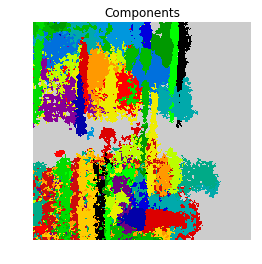

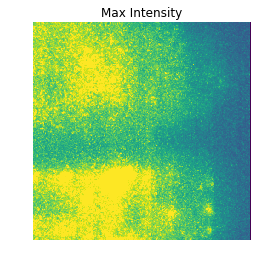

In [55]:
rand_block = (8, 5, 7, 0)
check_demix_cells(save_root, rand_block, plot_global=False, plot_mask=False)

In [56]:
from h5py import File

In [57]:
def fsave_name(save_root, block_id):
    fsave = f'{save_root}/cell_nmf_dff/period_Y_demix_block_'
    for _ in block_id:
        fsave += '_'+str(_)
    return fsave + '_rlt.h5'

In [58]:
fsave = fsave_name(save_root, rand_block)

In [64]:
with File(fsave, 'r') as f:
    A = f['A'].value
    F0 = f['cell_F0'].value
    dF = f['cell_dF'].value

In [66]:
# for n in range(A.shape[-1]):
#     plt.imshow(A[:, :, n].squeeze())
#     plt.title(n)
#     plt.show()

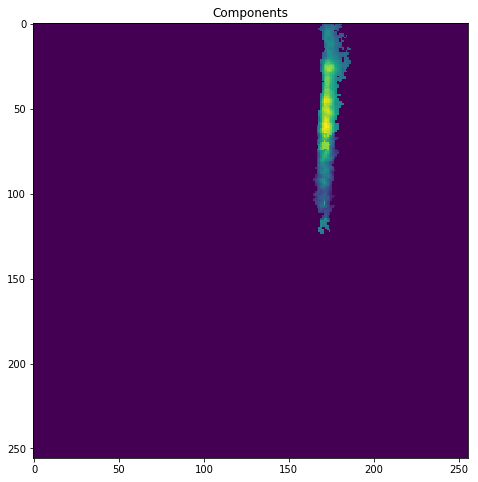

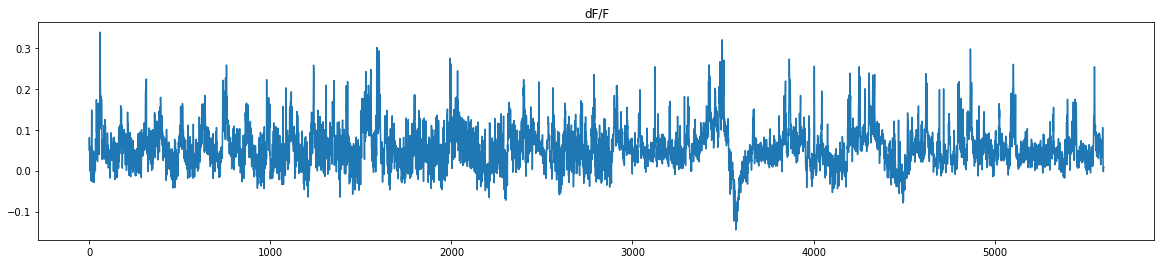

In [78]:
n = 18
plt.figure(figsize=(8, 8))
plt.imshow(A[:, :, n].squeeze())
plt.title('Components')
plt.show()
plt.figure(figsize=(20, 4))
plt.plot(dF[n]/F0[n])
plt.title('dF/F')
plt.show()

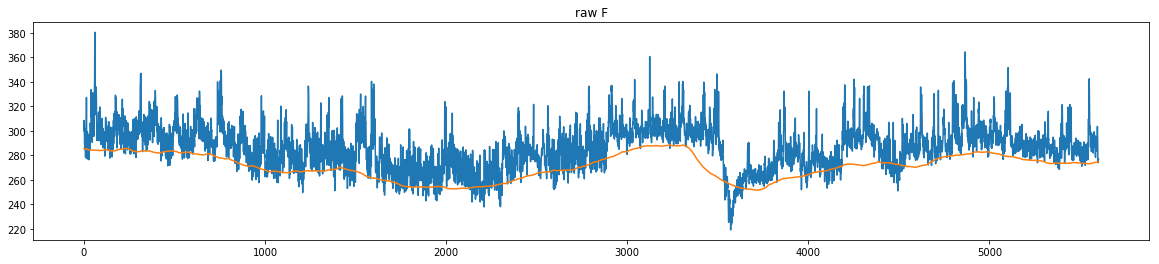

In [79]:
plt.figure(figsize=(20, 4))
plt.plot(dF[n]+F0[n])
plt.plot(F0[n])
plt.title('raw F')
plt.show()

In [6]:
rand_block = (8, 5, 7, 0)
trans_data_t = da.from_zarr(f'{save_root}/motion_corrected_data.zarr')
block_data = trans_data_t.blocks[rand_block].compute(scheduler='single-threaded')

In [7]:
block_data = block_data.squeeze()

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation
from matplotlib.animation import FFMpegFileWriter
plt.rcParams['animation.ffmpeg_path'] = '/groups/ahrens/home/weiz/anaconda/envs/myenv/bin/ffmpeg'

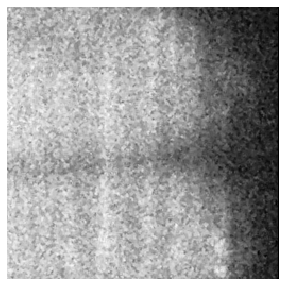

In [20]:
fig, axs = plt.subplots(figsize=(5,5))
axs.set_axis_off()
axs.set_xticklabels([])
axs.set_yticklabels([])
min_ = np.percentile(block_data, 0.1)
max_ = np.percentile(block_data, 99.9)
imgs = axs.imshow(block_data[:, :, 0], vmin=min_, vmax=max_, cmap="Greys_r")

def update(i):
    imgs.set_data(block_data[:, :, 0+i]);
    return imgs,

num_frames = 5000
fps = 60
filename = 'tmpblock.mp4'
ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=True);
mywriter = FFMpegFileWriter(fps=fps,codec="h264")
ani.save(filename, writer=mywriter)